In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
from utilities3 import *

from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)



In [2]:
################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d_block(nn.Module):
    '''FNO块，其中未实现激活函数'''
    def __init__(self, modes1, modes2, width):
        super().__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 1 # pad the domain if input is non-periodic
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x3 = self.w1(x)
        x = x1 + x2 + x + x3
        return x
    
class Permute(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.dim = args

    def forward(self, x):
        x = x.permute(dims=self.dim)
        return x
    
class Get_grid(nn.Module):
    def __init(self):
        super().__init__()

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        return x    

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(nn.Linear(3, width), Permute(0,3,1,2),
                    FNO2d_block(modes, modes, width), nn.ReLU(),
                    FNO2d_block(modes, modes, width), nn.ReLU(),
                    FNO2d_block(modes, modes, width), nn.ReLU(),
                    Permute(0, 2, 3, 1), nn.Linear(width, 128),  nn.ReLU(), 
                    nn.Linear(128, 1))
        
    def forward(self, x):
        x = self.shape_change(x)
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.net(x)
        x = self.shape_change(x)
        return x
        
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)
        
    def shape_change(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(dim=-1)
        elif len(x.shape) == 3:
            x = x.unsqueeze(dim=-1)
        elif len(x.shape) == 4:
            x = x.squeeze(dim=-1)
        return x

In [3]:
################################################################
# configs
################################################################
# TRAINPATH = '../data/piececonst_r421_N1024_smooth1.mat'
# TEST_PATH = 'data/piececonst_r421_N1024_smooth2.mat'

ntrain = 2000
ntest = 500

batch_size = 10
learning_rate = 0.001

epochs = 50
step_size = 100
gamma = 0.5

modes = 12
width = 32

r = 5
h = int(((241 - 1)/r) + 1)
s = h

################################################################
# load data and data normalization
################################################################
reader = MatReader('../data_2d/possion_data1.1_2d_2000_49.mat')
x_train = reader.read_field('f_train')[:ntrain,:,:][:,:s,:s]
y_train = reader.read_field('u_train')[:ntrain,:,:][:,:s,:s]


# reader.load_file(TEST_PATH)
x_test = reader.read_field('f_test')[:ntest,:,:][:,:s,:s]
y_test = reader.read_field('u_test')[:ntest,:,:][:,:s,:s]


x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

# x_train = x_train.reshape(ntrain,s,s,1)
# x_test = x_test.reshape(ntest,s,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                                          batch_size=batch_size, shuffle=False, drop_last=True)


In [4]:
################################################################
# training and evaluation
################################################################
model = Net()
model = model.cuda()
model.apply(xavier)
print(count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).reshape(batch_size, s, s)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_l2, test_l2)

torch.save(model.state_dict(), '../model_2d/params_possion_data1.1_2d_2000_49_fix2')

1804865
0 7.745975499999999 0.4114520390033722 0.19204932832717894
1 4.7698673 0.17347173246741296 0.13165676426887513
2 4.776609699999998 0.11768403270840645 0.08748579102754593
3 4.766674699999999 0.09851465383172035 0.06959346652030945
4 4.7696203 0.07987290278077125 0.08527555358409881
5 4.769800400000001 0.08638316798210144 0.10098031973838806
6 4.7947248000000044 0.06770879422128201 0.10142032337188721
7 4.790586400000002 0.0695755183249712 0.04902398294210434
8 4.781765 0.0624804045855999 0.07526544535160065
9 4.781456200000001 0.0519859286993742 0.04173283714056015
10 4.971338600000003 0.054685231700539585 0.04953248989582062
11 5.194234299999998 0.05813316085189581 0.042758692800998685
12 4.8000094000000075 0.05268917844444514 0.04663301944732666
13 4.797544000000002 0.056279079139232635 0.053183762669563296
14 4.776091699999995 0.0460675880536437 0.048637242913246156
15 4.775263899999999 0.05030651692301035 0.048354155659675595
16 4.7756140999999985 0.0505025250762701 0.03694

tensor([116])


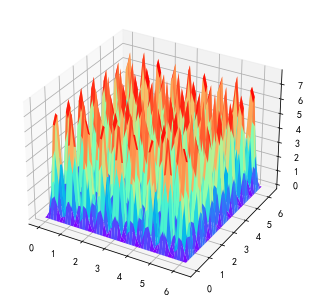

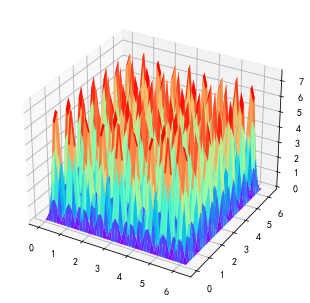

In [5]:
num=torch.randint(1,500,[1])
print(num)

x=np.linspace(0,2*np.pi,49)
y=x
X, Y = np.meshgrid(x, y)
Z = model(x_test[num,:,:].cuda())
Z = y_normalizer.decode(Z).cpu().detach().numpy().reshape(49,49)
fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X,Y,Z,cmap='rainbow')

Z_test = y_test[num,:,:].reshape(49,49)
fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X,Y,Z_test,cmap='rainbow')
plt.show()